<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Plan" data-toc-modified-id="Plan-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plan</a></span></li><li><span><a href="#Brownian-motion" data-toc-modified-id="Brownian-motion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Brownian motion</a></span></li><li><span><a href="#Monte-Carlo" data-toc-modified-id="Monte-Carlo-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Monte Carlo</a></span><ul class="toc-item"><li><span><a href="#UDF" data-toc-modified-id="UDF-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>UDF</a></span></li><li><span><a href="#Computations" data-toc-modified-id="Computations-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Computations</a></span></li></ul></li><li><span><a href="#LETF" data-toc-modified-id="LETF-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LETF</a></span><ul class="toc-item"><li><span><a href="#LETF-UDF" data-toc-modified-id="LETF-UDF-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>LETF UDF</a></span></li><li><span><a href="#Tables" data-toc-modified-id="Tables-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Tables</a></span></li><li><span><a href="#Plot-UDF" data-toc-modified-id="Plot-UDF-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Plot UDF</a></span></li><li><span><a href="#Computation" data-toc-modified-id="Computation-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Computation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Analysis</a></span></li></ul></li><li><span><a href="#Compunding-effect" data-toc-modified-id="Compunding-effect-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compunding effect</a></span></li></ul></div>

## Packages

In [5]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import os

## Data

We load prepared in xlsx file data for the underlyings TR

In [2]:
#link = 'Data/Underlyings from ICE.xlsx'

In [5]:
#Data = pd.read_excel(io=link, index_col=0, parse_dates=True)

# Calulate log difference
#Data['logdif_7_10'] = np.log(Data.Under_7_10) - np.log(Data.Under_7_10.shift(1)) 
#Data['logdif_20'] = np.log(Data.Under_20) - np.log(Data.Under_20.shift(1)) 

#Parameters = {}

#Parameters['All years'] = [Data.Under_7_10[-1],
#                             Data.logdif_7_10.mean(),
#                             Data.logdif_7_10.std()]

# Make horizon of 3 years
#Data2 = Data.loc['2019-02-28':'2021-02-28']

#Parameters['Three years'] = [Data2.Under_7_10[-1],
#                             Data2.logdif_7_10.mean(),
#                             Data2.logdif_7_10.std()]

## Plan

- Create Brownian motion, with simulation
- Create LETF and rebalance
- Create Monte Carlo

## Brownian motion

In [4]:
# UDF to generate error terms ( need for simple)
def Create_Errors(what,horizon):
    
    if what == 'Stand Norm':

        Stand_Residuals = [random.gauss(0,1) for x in range(horizon)]

    return Stand_Residuals

In [5]:
class Brownian_Motion(): # Currently for constant mu and sigma
    
    def __init__(self,Inital_Price, TimeDelta, mu, sigma):
        
        self.Inital_Price = float(Inital_Price)
        self.TimeDelta = int(TimeDelta)
        self.mu = float(mu)
        self.sigma = float(sigma)
        
    def Simulate_Prices(self,epsilons):
        
        predited_prices = []
        predited_prices.append([0,self.Inital_Price])
        
        for i, epsilon in enumerate(epsilons,start=1):
            
            if len(predited_prices) == 1:
                
                num1 = (self.mu - np.power(self.sigma,2)/2)*self.TimeDelta 
                num2 = self.sigma*epsilon*np.sqrt(self.TimeDelta)

                iPrice = self.Inital_Price*np.exp(num1-num2)

                predited_prices.append([i,iPrice])
                
            else:
                
                num1 = (self.mu - np.power(self.sigma,2)/2)*self.TimeDelta
                num2 = self.sigma*epsilon*np.sqrt(self.TimeDelta)

                iPrice = iPrice*np.exp(num1-num2)

                predited_prices.append([int(i),iPrice])
        
        predited_prices = pd.DataFrame(predited_prices)
        
        predited_prices.columns = ['day','price']
        
        predited_prices.set_index('day', inplace=True)
        
        return predited_prices
    
    def __repr__(self):
        return '''
Initial Price {0}
Time Delta {1}
Mu {2}
Sigma {3}
'''.format(self.Inital_Price,self.TimeDelta, self.mu,self.sigma)
        

## Monte Carlo

### UDF

In [6]:
def Monte_Carlo(Inital_Price, TimeDelta, mu, sigma,
                       n_simulations = 5000, 
                       error_type = 'Stand Norm', n_holding_days = 5):
    
    BM_i = Brownian_Motion(Inital_Price, TimeDelta, mu, sigma) # create brownian motion
    
    Simulated_DF = pd.DataFrame()
    
    for iSim in range(n_simulations): # For each simulation

        # create simulated errors
        Errors_i = Create_Errors(error_type,n_holding_days)

        # create returns of underlying for errors
        Simulation_i = BM_i.Simulate_Prices(Errors_i)
        
        # Rename column
        Simulation_i.columns = ['Price_'+str(iSim)]
        
        # Add data
        
        Simulated_DF = pd.concat([Simulated_DF, Simulation_i],axis=1)
        
    return Simulated_DF

### Computations

In [56]:
# We will assume 10% and 20% annualised expected mean and volatility 

mean_assumed = 0.1/252
sigma_assumed = 0.2/np.sqrt(252)

#  Code is  effient -> 1 min 59 seconds to generate all needed data for 10000

# I save data in order not to reproduce it each time

if not os.path.exists('Data/Simulated_typical.pkl'):

    Data_typical = Monte_Carlo(Inital_Price=1000,
                        TimeDelta=1,
                        mu=mean_assumed,
                        sigma=sigma_assumed,
                        n_holding_days=252,
                        n_simulations = 10000)

    Data_typical.to_pickle('Data/Simulated_typical.pkl')

else:
    
    Data_typical = pd.read_pickle('Data/Simulated_typical.pkl')
    
# We as well need data with double and half of volatility

# low
if not os.path.exists('Data/Simulated_typical_low.pkl'):

    Data_typical_low = Monte_Carlo(Inital_Price=1000,
                        TimeDelta=1,
                        mu=mean_assumed,
                        sigma=sigma_assumed*0.5,
                        n_holding_days=252,
                        n_simulations = 10000)

    Data_typical_low.to_pickle('Data/Simulated_typical_low.pkl')

else:
    
    Data_typical_low = pd.read_pickle('Data/Simulated_typical_low.pkl')

# high
if not os.path.exists('Data/Simulated_typical_high.pkl'):

    Data_typical_high = Monte_Carlo(Inital_Price=1000,
                        TimeDelta=1,
                        mu=mean_assumed,
                        sigma=sigma_assumed*2,
                        n_holding_days=252,
                        n_simulations = 10000)

    Data_typical_high.to_pickle('Data/Simulated_typical_high.pkl')

else:
    
    Data_typical_high = pd.read_pickle('Data/Simulated_typical_high.pkl')


## LETF

### LETF UDF

In [19]:
# Function to compue LETFs return

def Quick_LETF_Return(Index_return, Leverage, Fees=0):
    
    return Index_return*Leverage-Fees/252

In [20]:
# Function to compute LETF return based on certain underlying price series

def Create_LETF(Data,Leverage, Fees=0):
    
    NewData = Data.pct_change().fillna(0)

    NewData = NewData.apply(Quick_LETF_Return, args=(Leverage,Fees))

    NewData = NewData + 1

    NewData = NewData.cumprod()
    
    return NewData

In [59]:
# Computation of different LETFs

def Create_list_of_LETFs(iData_underlying, iFee=0.01):

    iLETF_list = []

    for iLeverage in [-3,-2,1,2,3]:

        if iLeverage != 1:
            
            iLETF_list.append(
                (iLeverage,Create_LETF(iData_underlying,iLeverage,iFee))
                                )
        else:
            
            iLETF_list.append(
                (iLeverage,Create_LETF(iData_underlying,iLeverage,0))
                                )
            
    return iLETF_list

### Tables

In [64]:
# Compute statistics

def Create_Table_1(iLETF_list):
    
    iTable_raw = {}

    for iLeverage,iLETF in iLETF_list:

        for iPeriod, iIndex in [('week',5-1),('month',21-1),('year',252-1)]:

            iDay = iLETF.loc[iIndex] # take the last day of a holding period

            iTable_raw[(iLeverage,iPeriod)] = {
                'Mean':iDay.mean(),
                'Median':iDay.median(),
                'Minimum':iDay.min(),
                'Maximum':iDay.max(),
                '5% percentile':iDay.quantile(0.05),
                '95% percentile':iDay.quantile(0.95)
            } 

    return pd.DataFrame.from_dict(iTable_raw)

#table_1.to_excel('Tables/Appendix_10.xlsx')

### Plot UDF

In [35]:
def plot_Hist(iDay,iName,iPeriod,iLeverage):
    
    plt.style.use('seaborn-ticks')

    fig, ax = plt.subplots(figsize=(10, 6))

    ax = iDay.hist(bins=50, density=False)

    ax.set_xlabel('Payoff, in times of seed capital')
    ax.set_ylabel('Frequency')
    ax.set_title(r'Histogram of NAV, period:{0}, leverage {1}x'.format(iPeriod,iLeverage))

    ax.grid()

    fig.savefig("Graphs/{0}.png".format(str(iName)))

    plt.show()

### Computation

In [60]:
# Computation of typical LETFs from previosly made underlying

iLETF_typical = Create_list_of_LETFs(Data_typical)
iLETF_typical_low = Create_list_of_LETFs(Data_typical_low)
iLETF_typical_high = Create_list_of_LETFs(Data_typical_high)

### Analysis

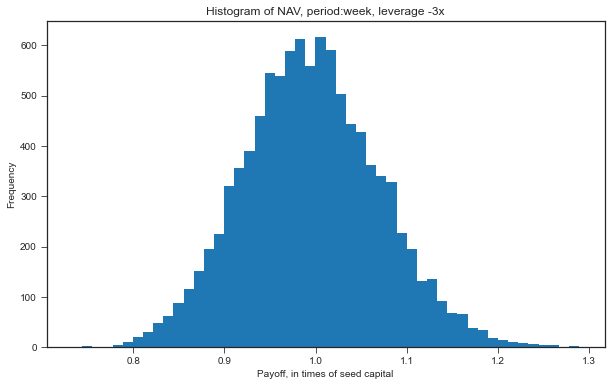

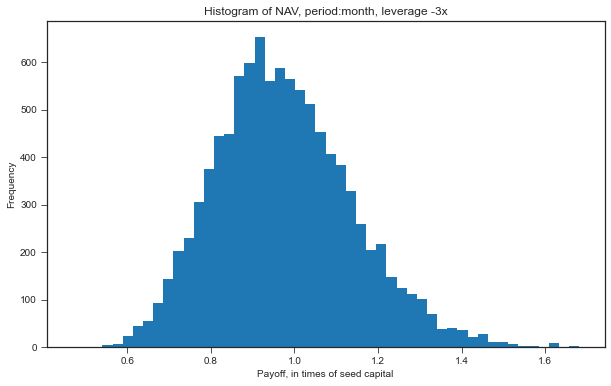

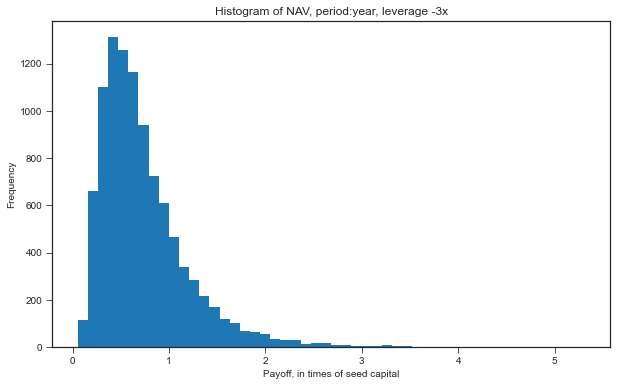

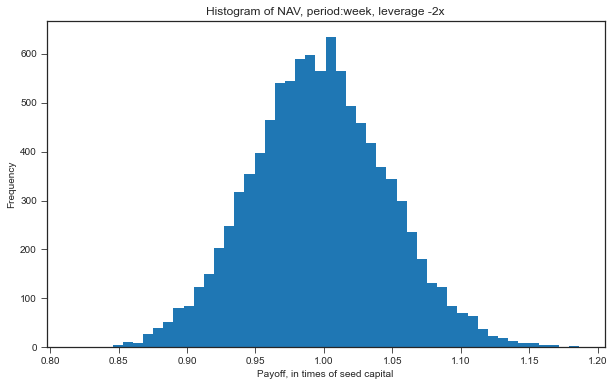

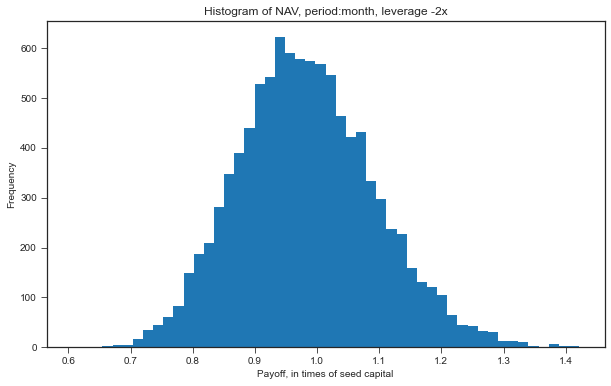

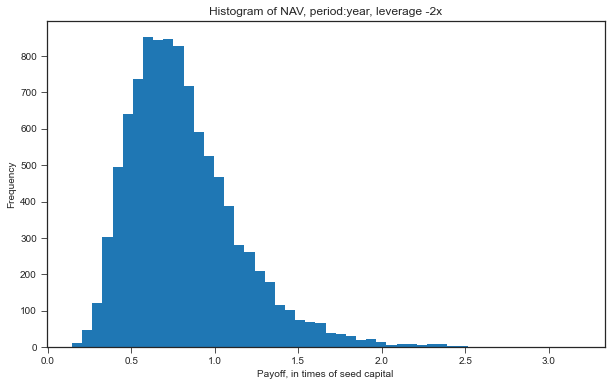

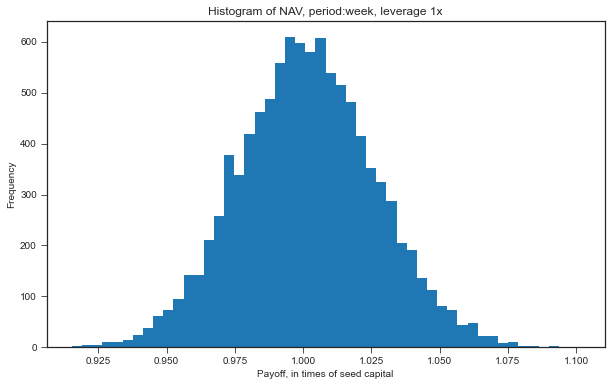

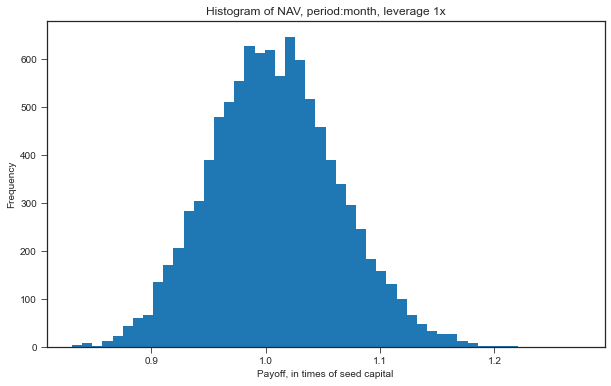

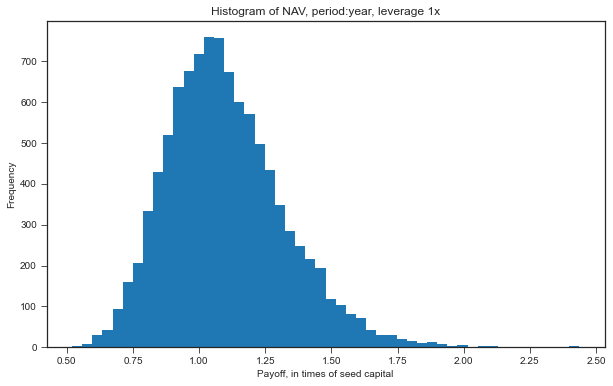

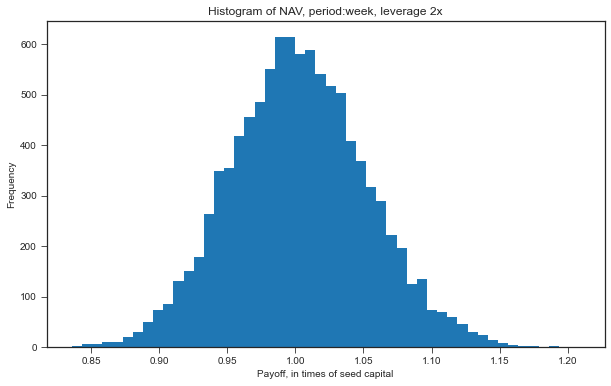

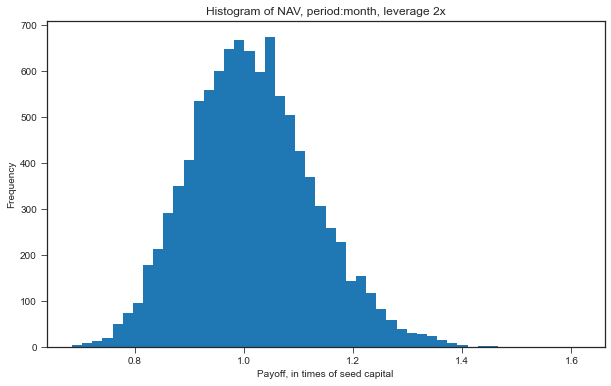

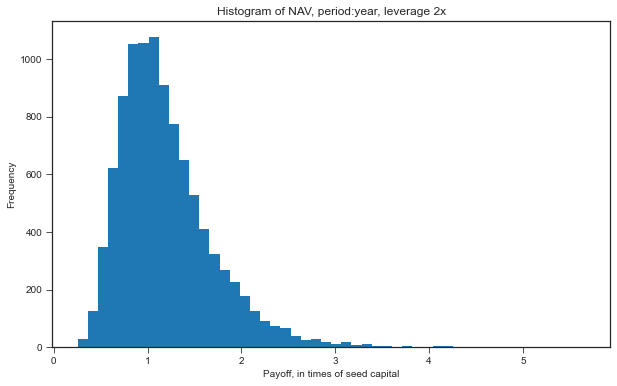

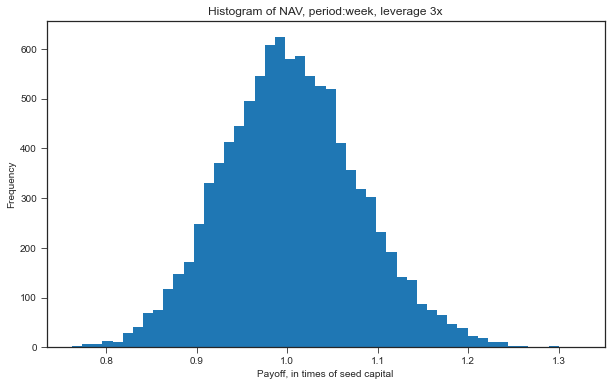

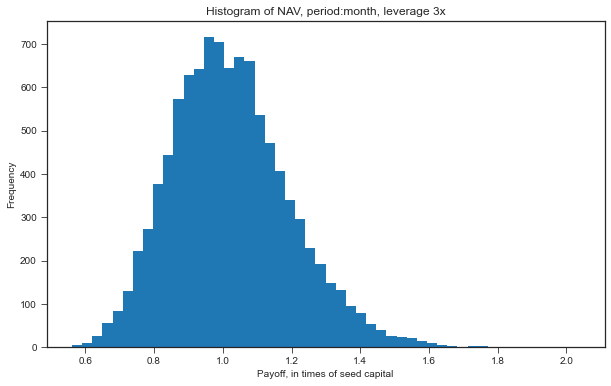

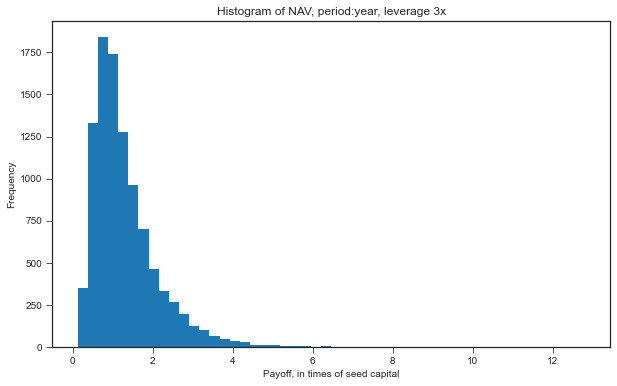

In [45]:
# Create Graphs of histogram for week, month and year and save it =) to attach in appendix

for iLeverage,iLETF in iLETF_typical:
    
    for iPeriod, iIndex in [('week',5-1),('month',21-1),('year',252-1)]:
        
        iDay = iLETF.loc[iIndex] # take the last day of a holding period

        plot_Hist(iDay,'{0}_{1}x'.format(iPeriod,iLeverage),iPeriod,iLeverage)

In [69]:
# Compute basic descriptive statistics

Appendix_13_base = Create_Table_1(iLETF_typical)
Appendix_13_low = Create_Table_1(iLETF_typical_low)
Appendix_13_high = Create_Table_1(iLETF_typical_high)

# Save to xlsx to present in papper appendix

Appendix_13_base.to_excel('Tables/Appendix_13_base.xlsx')
Appendix_13_low.to_excel('Tables/Appendix_13_low.xlsx')
Appendix_13_high.to_excel('Tables/Appendix_13_high.xlsx')

## Compunding effect

<ipython-input-25-71c57ca2f77e>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_neutral = pd.Series()


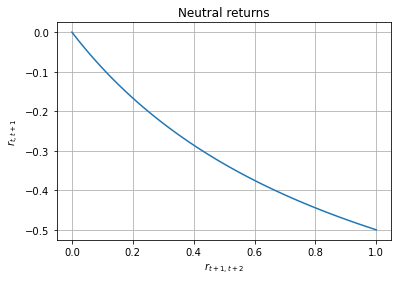

In [25]:
def netralise_return(iReturn):
    return 1/(1+iReturn)-1

df_neutral = pd.Series()

for iReturn in range(0,101):
    df_neutral.loc[iReturn/100] = netralise_return(iReturn/100)
    
fig, ax = plt.subplots()

ax = df_neutral.plot()
ax.set_xlabel(r'$r_{t+1,t+2}$')
ax.set_ylabel(r'$r_{t,t+1}$')
ax.set_title('Neutral returns')
ax.grid(True)
fig.savefig("Graphs/{0}.png".format('Neutral returns'))
plt.show()